In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as ddf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

In [2]:
data_dir = 'data/mimic-iv-1.0/physionet.org/files/mimiciv/1.0/'
core = data_dir+'core/' 
hosp = data_dir+'hosp/'
icu = data_dir+'icu/'

In [3]:
patients = pd.read_csv(core+'patients.csv', parse_dates=['dod'])
admissions = pd.read_csv(core+'admissions.csv', parse_dates=['admittime','dischtime','deathtime','edregtime','edouttime'])
transfers = pd.read_csv(core+'transfers.csv', parse_dates=['intime','outtime'])
icd = pd.read_csv(hosp+'d_icd_diagnoses.csv')
diagnoses_icd = pd.read_csv(hosp+'diagnoses_icd.csv')

In [4]:
labs_dtype = {
    "labevent_id": "Int64",
    "subject_id": "int64",
    "hadm_id": "Int64",
    "specimen_id": "Int64",
    "itemid": "Int64",
    "order_provider_id": "string",
    "value": "string",
    "valuenum": "float64",
    "valueuom": "string",
    "ref_range_lower": "float64",
    "ref_range_upper": "float64",
    "flag": "string",
    "priority": "string",
    "comments": "string"
}

In [5]:
labs = ddf.read_csv(hosp+'labevents.csv', dtype=labs_dtype, parse_dates=["charttime", "storetime"])

In [6]:
labitems = pd.read_csv(hosp+'d_labitems.csv')

In [7]:
neonatal_patients = patients[patients['anchor_age'] == 0]
len(neonatal_patients)

60872

In [8]:
diagnoses = diagnoses_icd.merge(icd, on=['icd_code', 'icd_version'], how='inner')
diagnoses.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title
0,15734973,20475282,3,2825,9,Sickle-cell trait
1,15734973,20475282,2,V0251,9,Carrier or suspected carrier of group B strept...
2,15734973,20475282,5,V270,9,"Outcome of delivery, single liveborn"
3,15734973,20475282,1,64891,9,Other current conditions classifiable elsewher...
4,15734973,20475282,4,66481,9,"Other specified trauma to perineum and vulva, ..."


In [9]:
diagnoses[diagnoses['icd_code'] == 76529]

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title


In [10]:
premature_diagnoses = diagnoses[((diagnoses['icd_code'].str.startswith('P07')) & (diagnoses['icd_version'] == 10)) | ((diagnoses['icd_code'].str.startswith('765')) & (diagnoses['icd_code'] != 76529) & (diagnoses['icd_version'] == 9))]

In [11]:
premature_patients = neonatal_patients[neonatal_patients['subject_id'].isin(premature_diagnoses['subject_id'])]
len(premature_patients)

8678

In [12]:
premature_patients_admissions = premature_patients.merge(admissions, on=['subject_id'], how='inner')
premature_patients_admissions = premature_patients_admissions.sort_values(['subject_id', 'admittime'])
premature_patients_admissions = premature_patients_admissions.drop_duplicates(subset=['subject_id'])
premature_patients_admissions = premature_patients_admissions[premature_patients_admissions['discharge_location'] != 'AGAINST ADVICE']
premature_patients_admissions['hospital_expire_flag'].value_counts()

hospital_expire_flag
0    8489
1     188
Name: count, dtype: int64

In [13]:
premature_patients_admissions[premature_patients_admissions['hospital_expire_flag'] == 1]['discharge_location'].value_counts()

discharge_location
DIED                181
HOME                  2
ACUTE HOSPITAL        1
HOME HEALTH CARE      1
Name: count, dtype: int64

In [14]:
premature_patients_admissions[premature_patients_admissions['hospital_expire_flag'] == 0]['discharge_location'].value_counts()

discharge_location
HOME                        3747
HOME HEALTH CARE            3208
ACUTE HOSPITAL              1401
HEALTHCARE FACILITY           59
SKILLED NURSING FACILITY      41
REHAB                         20
OTHER FACILITY                 5
HOSPICE                        2
DIED                           1
Name: count, dtype: int64

In [15]:
premature_patients_admissions = premature_patients_admissions[
    ((premature_patients_admissions['hospital_expire_flag'] == 1) & (premature_patients_admissions['discharge_location'] == 'DIED')) |
    ((premature_patients_admissions['hospital_expire_flag'] == 0) & (premature_patients_admissions['discharge_location'].isin(['HOME', 'HOME HEALTH CARE'])))
]
premature_patients_admissions['hospital_expire_flag'].value_counts()

hospital_expire_flag
0    6955
1     181
Name: count, dtype: int64

In [16]:
nicu_transfers = transfers[transfers['careunit'] == 'Neonatal Intensive Care Unit (NICU)']
nicu_transfers.head()

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
73784,14312010,29997871.0,32892824,admit,Neonatal Intensive Care Unit (NICU),2118-10-25 02:07:31,2118-10-25 04:14:02
73786,14312010,29997871.0,30037787,transfer,Neonatal Intensive Care Unit (NICU),2118-10-25 04:14:02,2118-10-25 04:50:33
73789,15023067,27017665.0,30129282,transfer,Neonatal Intensive Care Unit (NICU),2127-11-27 05:28:31,2127-11-27 06:21:38
73790,15023067,27017665.0,35738088,transfer,Neonatal Intensive Care Unit (NICU),2127-11-27 06:21:38,2127-11-27 07:41:44
73804,19197569,29780270.0,39194191,transfer,Neonatal Intensive Care Unit (NICU),2185-04-01 01:22:57,2185-04-01 02:32:02


In [17]:
premature_nicu = premature_patients_admissions.merge(nicu_transfers, on=['subject_id', 'hadm_id'], how='inner')
premature_nicu = premature_nicu.sort_values(['subject_id', 'intime'])
premature_nicu = premature_nicu.drop_duplicates(subset=['subject_id'])
len(premature_nicu)

4525

In [18]:
premature_nicu['hospital_expire_flag'].value_counts()

hospital_expire_flag
0    4369
1     156
Name: count, dtype: int64

In [19]:
premature_nicu['nicu_admit_diff'] = (pd.to_datetime(premature_nicu['intime']) - pd.to_datetime(premature_nicu['admittime'])).astype(int)/(10**9)/60/60

In [20]:
premature_nicu_filtered = premature_nicu.loc[(premature_nicu['nicu_admit_diff'] <= 24) & (premature_nicu['nicu_admit_diff'] >= 0)]

In [21]:
final_cohort = premature_nicu_filtered.copy()
final_cohort['hospital_expire_flag'].value_counts()

hospital_expire_flag
0    4208
1     153
Name: count, dtype: int64

In [22]:
dead_cohort = final_cohort[final_cohort['hospital_expire_flag'] == 1].copy()
dead_2 = dead_cohort[dead_cohort['dischtime'] != dead_cohort['deathtime']]
dead_2['deathtime'] - dead_2['dischtime']

562       0 days 13:07:00
1313      0 days 02:02:00
2673      0 days 20:24:00
3507      0 days 15:45:00
3979      0 days 01:01:00
5353      0 days 12:58:00
5629      0 days 06:40:00
6331      0 days 21:25:00
8943      0 days 21:25:00
9174      0 days 16:14:00
9261      0 days 00:47:00
9582      0 days 00:51:00
10672   -1 days +23:58:00
10731     0 days 02:21:00
dtype: timedelta64[ns]

In [23]:
final_cohort['disch_nicu_diff'] = np.where(
        final_cohort['hospital_expire_flag'] == 0,
        final_cohort['dischtime'],
        final_cohort['deathtime']
    ).astype(int)/(10**9)/60/60 - final_cohort['intime'].astype(int)/(10**9)/60/60
final_cohort['disch_admit_diff'] = np.where(
        final_cohort['hospital_expire_flag'] == 0,
        final_cohort['dischtime'],
        final_cohort['deathtime']
    ).astype(int)/(10**9)/60/60 - final_cohort['admittime'].astype(int)/(10**9)/60/60
final_cohort = final_cohort[(final_cohort['disch_admit_diff'] > 0) & (final_cohort['disch_nicu_diff'] > 0)]

In [24]:
dead_cohort = final_cohort[final_cohort['hospital_expire_flag'] == 1].copy()

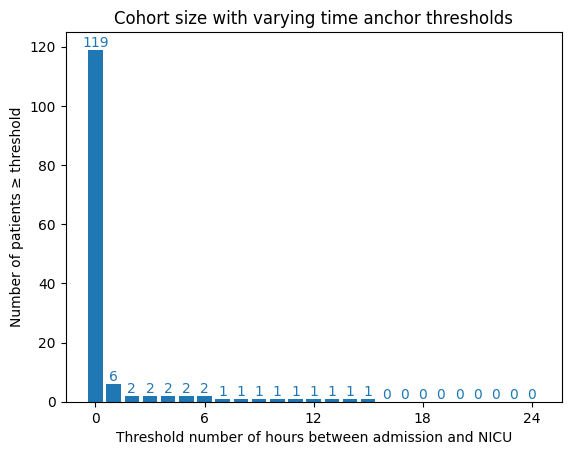

In [25]:
bars = plt.bar(range(25), [len(dead_cohort[dead_cohort['nicu_admit_diff'] >= t]) for t in range(25)])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), ha='center', va='bottom', fontsize=10, color='C0')
plt.xlabel("Threshold number of hours between admission and NICU")
plt.ylabel("Number of patients ≥ threshold")
plt.title("Cohort size with varying time anchor thresholds")
plt.xticks(range(0,25,6))
plt.show()

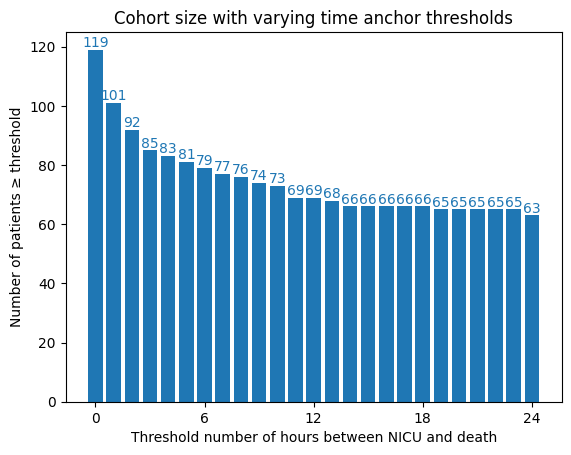

In [26]:
bars = plt.bar(range(25), [len(dead_cohort[dead_cohort['disch_nicu_diff'] >= t]) for t in range(25)])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), ha='center', va='bottom', fontsize=10, color='C0')
plt.xlabel("Threshold number of hours between NICU and death")
plt.ylabel("Number of patients ≥ threshold")
plt.title("Cohort size with varying time anchor thresholds")
plt.xticks(range(0,25,6))
plt.show()

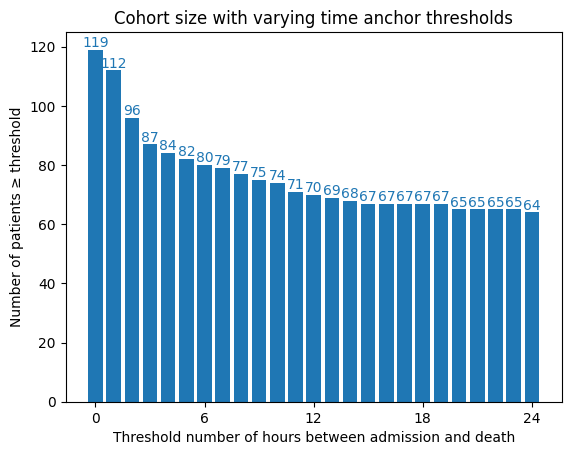

In [27]:
bars = plt.bar(range(25), [len(dead_cohort[dead_cohort['disch_admit_diff'] >= t]) for t in range(25)])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), ha='center', va='bottom', fontsize=10, color='C0')
plt.xlabel("Threshold number of hours between admission and death")
plt.ylabel("Number of patients ≥ threshold")
plt.title("Cohort size with varying time anchor thresholds")
plt.xticks(range(0,25,6))
plt.show()

In [28]:
t0 = 6
final_cohort = final_cohort[final_cohort['disch_nicu_diff'] >= t0]
final_cohort['hospital_expire_flag'].value_counts()

hospital_expire_flag
0    4208
1      79
Name: count, dtype: int64

In [29]:
ga_map = {
    10: {
        'P0720': 'UNK',
        'P0721': '<=24',
        'P0722': '<=24',
        'P0723': '<=24',
        'P0724': '25-26',
        'P0725': '25-26',
        'P0726': '27-28',
        'P0730': 'UNK',
        'P0731': '27-28',
        'P0732': '29-30',
        'P0733': '29-30',
        'P0734': '31-32',
        'P0735': '31-32',
        'P0736': '33-34',
        'P0737': '33-34',
        'P0738': '35-36',
        'P0739': '35-36',
    },
    9: {
        '76520': 'UNK',
        '76521': '<=24',
        '76522': '<=24',
        '76523': '25-26',
        '76524': '27-28',
        '76525': '29-30',
        '76526': '31-32',
        '76527': '33-34',
        '76528': '35-36',
        '76529': '>36',
    }
}
ga = [
    '<=24',
    '25-26',
    '27-28',
    '29-30',
    '31-32',
    '33-34',
    '35-36',
    '>36',
    'UNK'
]

In [30]:
bw_map = {
    10: {
        'P0700': 'UNK',
        'P0701': '<500',
        'P0702': '500-749',
        'P0703': '750-999',
        'P0710': 'UNK',
        'P0714': '1000-1249',
        'P0715': '1250-1499',
        'P0716': '1500-1749',
        'P0717': '1750-1999',
        'P0718': '2000-2499',
    },
    9: {
        '76500': 'UNK',
        '76501': '<500',
        '76502': '500-749',
        '76503': '750-999',
        '76504': '1000-1249',
        '76505': '1250-1499',
        '76506': '1500-1749',
        '76507': '1750-1999',
        '76508': '2000-2499',
        '76509': '>2500',
        '76510': 'UNK',
        '76500': 'UNK',
        '76511': '<500',
        '76512': '500-749',
        '76513': '750-999',
        '76514': '1000-1249',
        '76515': '1250-1499',
        '76516': '1500-1749',
        '76517': '1750-1999',
        '76518': '2000-2499',
        '76519': '>2500',
    }
}
bw = [
    '<500',
    '500-749',
    '750-999',
    '1000-1249',
    '1250-1499',
    '1500-1749',
     '1750-1999',
    '2000-2499',
    '>2500',
    'UNK'
]

In [31]:
def map_to_df(mapping, feature):
    rows = [(version, code, category) for version, codes in mapping.items() for code, category in codes.items()]
    return pd.DataFrame(rows, columns=['icd_version', 'icd_code', feature])

ga_df = map_to_df(ga_map, 'ga')
bw_df = map_to_df(bw_map, 'bw')

In [32]:
ga_diagnoses = premature_diagnoses.merge(ga_df, on=['icd_version', 'icd_code'], how='left')
bw_diagnoses = premature_diagnoses.merge(bw_df, on=['icd_version', 'icd_code'], how='left')

In [33]:
ga_bw_diagnoses = pd.concat([
    ga_diagnoses[['subject_id', 'ga']],
    bw_diagnoses[['subject_id', 'bw']]
])

In [34]:
ga_bw_patients = ga_bw_diagnoses.groupby('subject_id', as_index=False).agg({'ga': 'first', 'bw': 'first'})
ga_bw_patients.head()

,subject_id,ga,bw
0,10002179,35-36,>2500
1,10005213,33-34,2000-2499
2,10005325,33-34,>2500
3,10005967,33-34,1500-1749
4,10006516,31-32,1500-1749


In [35]:
final_cohort_ga_bw = final_cohort.merge(ga_bw_patients, on='subject_id', how='inner')
final_cohort_ga_bw.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,hadm_id,admittime,dischtime,deathtime,...,transfer_id,eventtype,careunit,intime,outtime,nicu_admit_diff,disch_nicu_diff,disch_admit_diff,ga,bw
0,10005213,F,0,2174,2008 - 2010,NaT,25783575,2174-08-23 17:39:00,2174-09-13 15:00:00,NaT,...,33511447,admit,Neonatal Intensive Care Unit (NICU),2174-08-23 17:48:54,2174-08-23 17:58:28,0.165000,501.185000,501.35,33-34,2000-2499
1,10005325,F,0,2154,2011 - 2013,NaT,20047480,2154-12-15 14:10:00,2154-12-21 11:10:00,NaT,...,39663534,admit,Neonatal Intensive Care Unit (NICU),2154-12-15 14:23:12,2154-12-15 14:28:49,0.220000,140.780000,141.00,33-34,>2500
2,10011828,M,0,2146,2014 - 2016,NaT,24514045,2146-12-23 04:05:00,2147-01-10 12:59:00,NaT,...,31568966,admit,Neonatal Intensive Care Unit (NICU),2146-12-23 04:08:44,2146-12-23 04:23:24,0.062222,440.837778,440.90,35-36,2000-2499
3,10012663,F,0,2171,2011 - 2013,NaT,27340067,2171-05-18 10:54:00,2171-07-21 15:30:00,NaT,...,39415613,admit,Neonatal Intensive Care Unit (NICU),2171-05-18 11:05:04,2171-05-18 11:14:30,0.184444,1540.415556,1540.60,27-28,750-999
4,10012883,M,0,2113,2011 - 2013,NaT,27742103,2113-03-26 02:30:00,2113-04-07 11:54:00,NaT,...,31961686,admit,Neonatal Intensive Care Unit (NICU),2113-03-26 03:18:02,2113-03-26 03:56:01,0.800556,296.599444,297.40,35-36,>2500


In [36]:
ga_counts = final_cohort_ga_bw['ga'].value_counts().reindex(ga)
bw_counts = final_cohort_ga_bw['bw'].value_counts().reindex(bw)

In [37]:
ga_outcome_counts = final_cohort_ga_bw.groupby(['ga', 'hospital_expire_flag']).size().reset_index(name='count')
ga_outcome_counts['ga'] = pd.Categorical(ga_outcome_counts['ga'], categories=ga, ordered=True)
ga_outcome_counts['hospital_expire_flag'] = pd.Categorical(ga_outcome_counts['hospital_expire_flag'], categories=[0,1], ordered=True)
ga_outcome_counts = ga_outcome_counts.sort_values(['ga','hospital_expire_flag'])
ga_outcome_counts

,ga,hospital_expire_flag,count
12,<=24,0,55
13,<=24,1,27
0,25-26,0,107
1,25-26,1,19
2,27-28,0,201
3,27-28,1,13
4,29-30,0,298
5,29-30,1,6
6,31-32,0,550
7,31-32,1,3


In [38]:
bw_outcome_counts = final_cohort_ga_bw.groupby(['bw', 'hospital_expire_flag']).size().reset_index(name='count')
bw_outcome_counts['bw'] = pd.Categorical(bw_outcome_counts['bw'], categories=bw, ordered=True)
bw_outcome_counts['hospital_expire_flag'] = pd.Categorical(bw_outcome_counts['hospital_expire_flag'], categories=[0,1], ordered=True)
bw_outcome_counts = bw_outcome_counts.sort_values(['bw','hospital_expire_flag'])
bw_outcome_counts

,bw,hospital_expire_flag,count
14,<500,0,8
15,<500,1,7
10,500-749,0,101
11,500-749,1,33
12,750-999,0,160
13,750-999,1,15
0,1000-1249,0,229
1,1000-1249,1,7
2,1250-1499,0,270
3,1250-1499,1,3


In [39]:
ga_outcome_counts = ga_outcome_counts.pivot(index='ga', columns='hospital_expire_flag', values='count').reindex(ga)
bw_outcome_counts = bw_outcome_counts.pivot(index='bw', columns='hospital_expire_flag', values='count').reindex(bw)

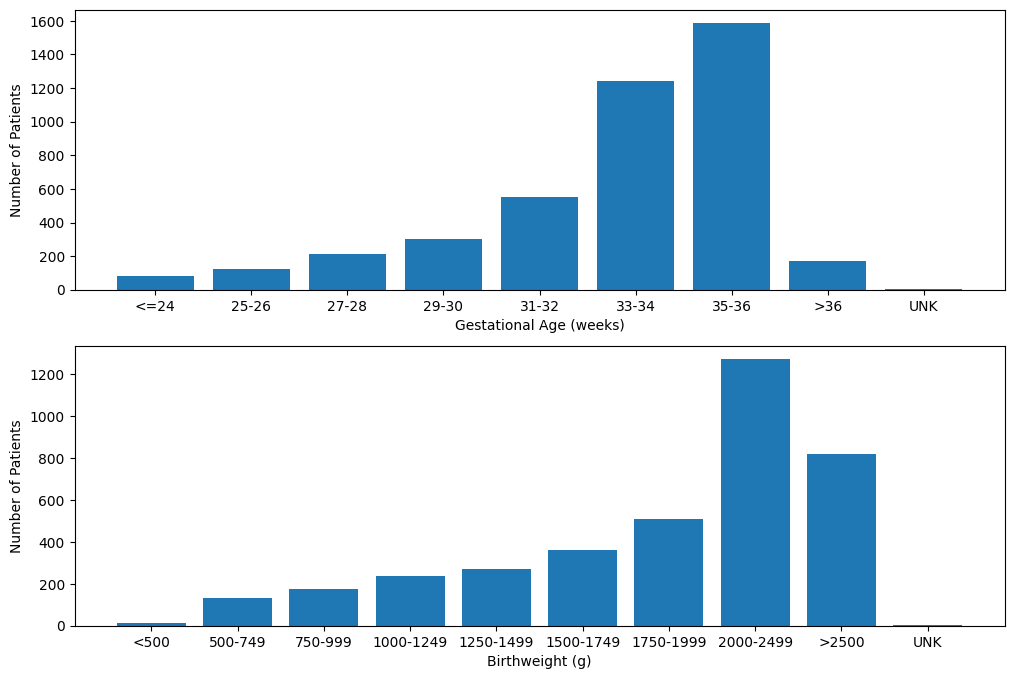

In [40]:
fig, ax = plt.subplots(2, figsize=(12,8))
ax[0].bar(ga_counts.index, ga_counts.values)
ax[0].set_xlabel('Gestational Age (weeks)')
ax[0].set_ylabel('Number of Patients')
ax[1].bar(bw_counts.index, bw_counts.values)
ax[1].set_xlabel('Birthweight (g)')
ax[1].set_ylabel('Number of Patients')
fig.show()

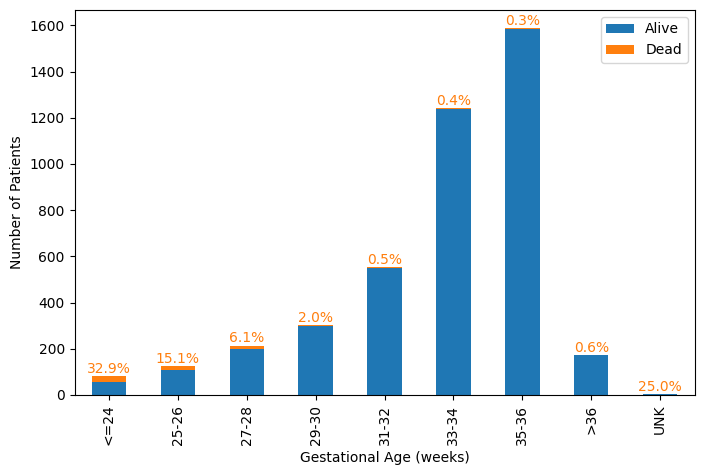

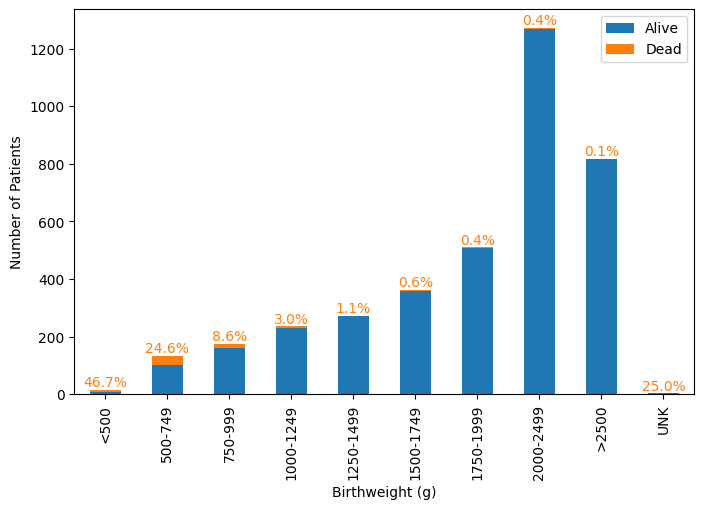

In [41]:
ax = ga_outcome_counts.plot(kind='bar', stacked=True, figsize=(8,5))
for i, x in enumerate(ga_outcome_counts.index):
    alive = ga_outcome_counts.loc[x, 0]
    dead = ga_outcome_counts.loc[x, 1]
    total = alive + dead
    if total > 0:
        pct_dead = 100 * dead / total
        ax.text(i, total + 1, f"{pct_dead:.1f}%", ha='center', va='bottom', fontsize=10, color='C1')
ax.set_xlabel('Gestational Age (weeks)')
ax.set_ylabel('Number of Patients')
ax.legend(labels=['Alive', 'Dead'])
ax = bw_outcome_counts.plot(kind='bar', stacked=True, figsize=(8,5))
for i, x in enumerate(bw_outcome_counts.index):
    alive = bw_outcome_counts.loc[x, 0]
    dead = bw_outcome_counts.loc[x, 1]
    total = alive + dead
    if total > 0:
        pct_dead = 100 * dead / total
        ax.text(i, total + 1, f"{pct_dead:.1f}%", ha='center', va='bottom', fontsize=10, color='C1')
ax.set_xlabel('Birthweight (g)')
ax.set_ylabel('Number of Patients')
ax.legend(labels=['Alive', 'Dead'])
plt.show()

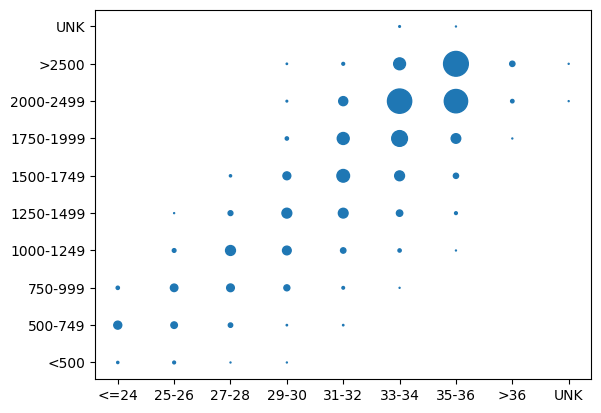

In [42]:
ga_bw_counts = final_cohort_ga_bw.groupby(['ga', 'bw']).size().reset_index(name='count')
ga_bw_counts['bw'] = pd.Categorical(ga_bw_counts['bw'], categories=bw, ordered=True)
ga_bw_counts['ga'] = pd.Categorical(ga_bw_counts['ga'], categories=ga, ordered=True)
ga_bw_counts = ga_bw_counts.sort_values(['ga','bw'])
plt.scatter(ga_bw_counts['ga'], ga_bw_counts['bw'], s=ga_bw_counts['count']/2)

In [43]:
bw_by_ga = pd.crosstab(final_cohort_ga_bw['ga'], final_cohort_ga_bw['bw'], normalize='index').reindex(ga, columns=bw)
bw_by_ga

bw,<500,500-749,750-999,1000-1249,1250-1499,1500-1749,1750-1999,2000-2499,>2500,UNK
ga,,,,,,,,,,
<=24,0.060976,0.804878,0.134146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25-26,0.064000,0.352000,0.464000,0.112000,0.008000,0.000000,0.000000,0.000000,0.000000,0.000000
27-28,0.004717,0.094340,0.287736,0.476415,0.113208,0.023585,0.000000,0.000000,0.000000,0.000000
29-30,0.003356,0.006711,0.124161,0.261745,0.335570,0.214765,0.036913,0.010067,0.006711,0.000000
31-32,0.000000,0.003690,0.012915,0.055351,0.180812,0.304428,0.271218,0.156827,0.014760,0.000000
33-34,0.000000,0.000000,0.000858,0.009434,0.036021,0.085763,0.219554,0.521441,0.124357,0.002573
35-36,0.000000,0.000000,0.000000,0.000752,0.006020,0.021068,0.071482,0.423627,0.476298,0.000752
>36,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.285714,0.690476,0.000000
UNK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000


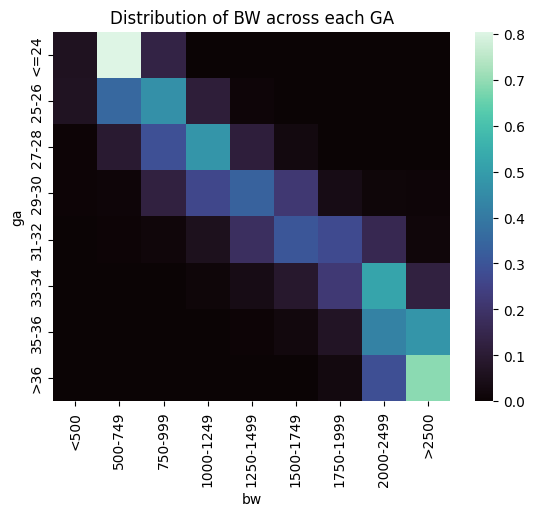

In [44]:
sns.heatmap(bw_by_ga.iloc[:-1,:-1], cmap='mako')
plt.title('Distribution of BW across each GA')
plt.show()

In [45]:
ga_by_bw = pd.crosstab(final_cohort_ga_bw['bw'], final_cohort_ga_bw['ga'], normalize='index').reindex(bw, columns=ga)
ga_by_bw

ga,<=24,25-26,27-28,29-30,31-32,33-34,35-36,>36,UNK
bw,,,,,,,,,
<500,0.333333,0.533333,0.066667,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000
500-749,0.492537,0.328358,0.149254,0.014925,0.014925,0.000000,0.000000,0.000000,0.000000
750-999,0.062857,0.331429,0.348571,0.211429,0.040000,0.005714,0.000000,0.000000,0.000000
1000-1249,0.000000,0.059574,0.429787,0.331915,0.127660,0.046809,0.004255,0.000000,0.000000
1250-1499,0.000000,0.003663,0.087912,0.366300,0.358974,0.153846,0.029304,0.000000,0.000000
1500-1749,0.000000,0.000000,0.013812,0.176796,0.455801,0.276243,0.077348,0.000000,0.000000
1750-1999,0.000000,0.000000,0.000000,0.021569,0.288235,0.501961,0.186275,0.001961,0.000000
2000-2499,0.000000,0.000000,0.000000,0.002358,0.066824,0.477987,0.442610,0.009434,0.000786
>2500,0.000000,0.000000,0.000000,0.002445,0.009780,0.177262,0.773839,0.035452,0.001222


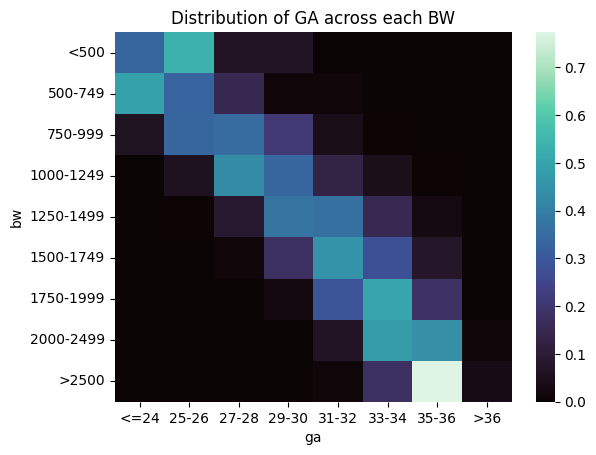

In [46]:
sns.heatmap(ga_by_bw.iloc[:-1,:-1], cmap='mako')
plt.title('Distribution of GA across each BW')
plt.show()

In [47]:
final_cohort = final_cohort_ga_bw

In [48]:
sex = final_cohort['gender'].value_counts(dropna=False)
sex_prop = [num/len(final_cohort)*100 for num in sex]
sex_prop

[53.67389783065081, 46.32610216934919]

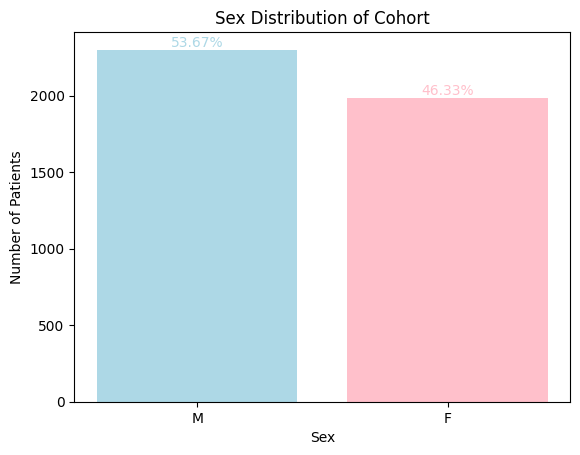

In [49]:
sex = final_cohort['gender'].value_counts(dropna=False)
sex_prop = [num/len(final_cohort)*100 for num in sex]
bars = plt.bar(sex.index, sex.values, color=['lightblue', 'pink'])
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, 
            f'{sex_prop[i]:.2f}%', ha='center', va='bottom', color=['lightblue', 'pink'][i])
plt.ylabel("Number of Patients")
plt.xlabel("Sex")
plt.title("Sex Distribution of Cohort")
plt.show()

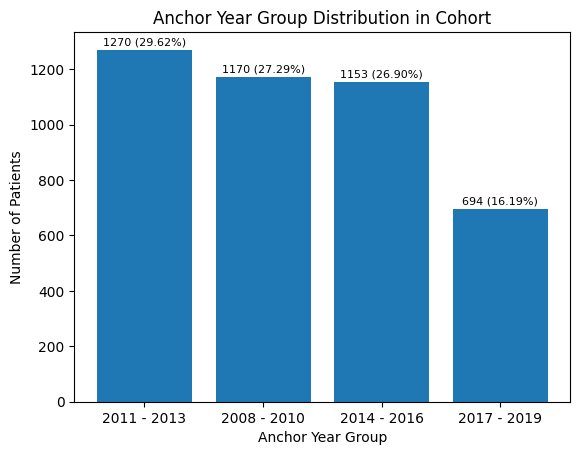

In [50]:
anchor_year_group = final_cohort['anchor_year_group'].value_counts()
bars = plt.bar(anchor_year_group.index, anchor_year_group.values)
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, 
            f'{anchor_year_group.values[i]} ({anchor_year_group.values[i]/len(final_cohort)*100:.2f}%)', ha='center', va='bottom', fontsize=8)
plt.xlabel("Anchor Year Group")
plt.ylabel("Number of Patients")
plt.title("Anchor Year Group Distribution in Cohort")
plt.show()

In [51]:
final_cohort['hospital_expire_flag'].value_counts()

hospital_expire_flag
0    4208
1      79
Name: count, dtype: int64

In [52]:
final_cohort_ddf = ddf.from_pandas(final_cohort, npartitions=1)

In [53]:
final_cohort_labs_ddf = labs.merge(final_cohort_ddf[['subject_id','hospital_expire_flag','admittime','intime']], on='subject_id', how='inner')

In [54]:
final_cohort_labs = final_cohort_labs_ddf.compute()

In [55]:
final_cohort_labs = final_cohort_labs.merge(labitems, on='itemid')

In [56]:
final_cohort_labs = final_cohort_labs[(final_cohort_labs['charttime'].astype(int)/(10**9)/60/60) >= (final_cohort_labs['admittime']).astype(int)/(10**9)/60/60]

In [57]:
final_cohort_labs_t0 = final_cohort_labs[(final_cohort_labs['charttime'].astype(int)/(10**9)/60/60) < (final_cohort_labs['intime']).astype(int)/(10**9)/60/60 + t0]

In [58]:
final_cohort_labs_t0['fluid'].value_counts() / len(final_cohort_labs_t0)

fluid
Blood                  0.997900
Urine                  0.001084
Cerebrospinal Fluid    0.000815
Pleural                0.000192
Other Body Fluid       0.000008
Name: count, dtype: float64

In [59]:
final_cohort_labs_t0[final_cohort_labs_t0['label'] == 'Intubated'].drop_duplicates('subject_id')['hospital_expire_flag'].value_counts()

hospital_expire_flag
0    240
1     11
Name: count, dtype: int64

In [60]:
set(final_cohort_labs_t0['label'])

{'Absolute Basophil Count',
 'Absolute Eosinophil Count',
 'Absolute Lymphocyte Count',
 'Absolute Monocyte Count',
 'Absolute Neutrophil Count',
 'Acanthocytes',
 'Alanine Aminotransferase (ALT)',
 'Albumin',
 'Albumin, Pleural',
 'Alkaline Phosphatase',
 'Alveolar-arterial Gradient',
 'Amphetamine Screen, Urine',
 'Amylase, Pleural',
 'Anion Gap',
 'Anisocytosis',
 'Asparate Aminotransferase (AST)',
 'Atypical Lymphocytes',
 'Bands',
 'Barbiturate Screen, Urine',
 'Base Excess',
 'Basophilic Stippling',
 'Basophils',
 'Benzodiazepine Screen, Urine',
 'Bicarbonate',
 'Bilirubin, Direct',
 'Bilirubin, Indirect',
 'Bilirubin, Total',
 'Bite Cells',
 'Blasts',
 'Blood Parasite Smear',
 'Calcium, Total',
 'Calculated TBG',
 'Calculated Thyroxine (T4) Index',
 'Calculated Total CO2',
 'Chloride',
 'Cocaine, Urine',
 'Cortisol',
 'Creatinine',
 'Creatinine, Pleural',
 'DHEA-Sulfate',
 'EDTA Hold',
 'Echinocytes',
 'Elliptocytes',
 'Envelope Cells',
 'Eosinophils',
 'Factor VIII',
 'Fibrinog

In [61]:
key = ['subject_id']
lab_covariates = [
    'charttime', 
    'valuenum', 
    'label', 
    'flag'
]
patient_covariates = [
    'gender', 
    'ga', 
    'bw', 
    'admittime', 
    'intime', 
    'dischtime', 
    'deathtime', 
    'anchor_year', 
    'anchor_year_group'
]
covariates = patient_covariates + lab_covariates
outcome = 'hospital_expire_flag'

In [62]:
relevant_labs = ['Base Excess', 'pH', 'pO2', 'pCO2', 'Intubated'] # Units: mEq/L, units, mm Hg, mm Hg

In [63]:
final_labs = final_cohort_labs_t0[key + lab_covariates]
latest_measurement = ['Base Excess', 'pO2', 'pCO2', 'Intubated'] 
lowest_measurement = ['pH']
final_labs = final_labs[final_labs['label'].isin(relevant_labs)]
final_labs.head()

,subject_id,charttime,valuenum,label,flag
45,10012663,2171-05-18 11:26:00,-14.00,Base Excess,<NA>
47,10012663,2171-05-18 11:26:00,43.00,pCO2,<NA>
48,10012663,2171-05-18 13:14:00,-5.00,Base Excess,<NA>
51,10012663,2171-05-18 13:14:00,41.00,pCO2,<NA>
52,10012663,2171-05-18 13:14:00,7.31,pH,abnormal


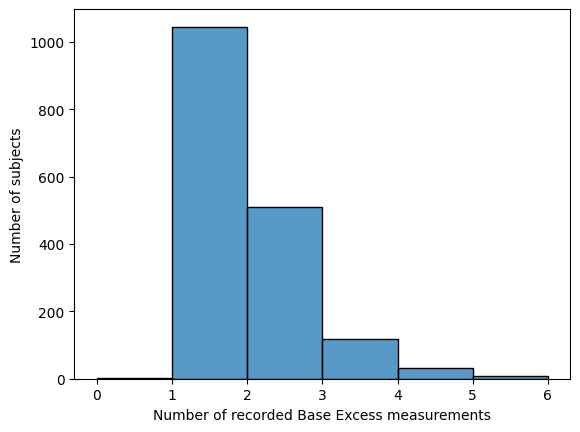

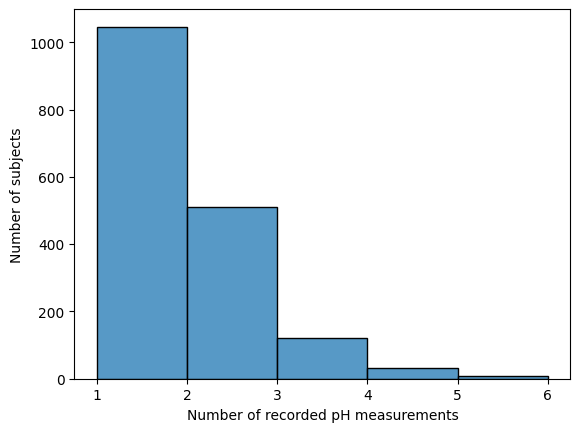

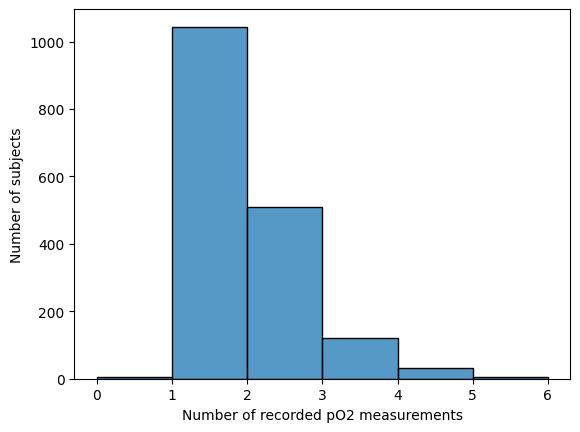

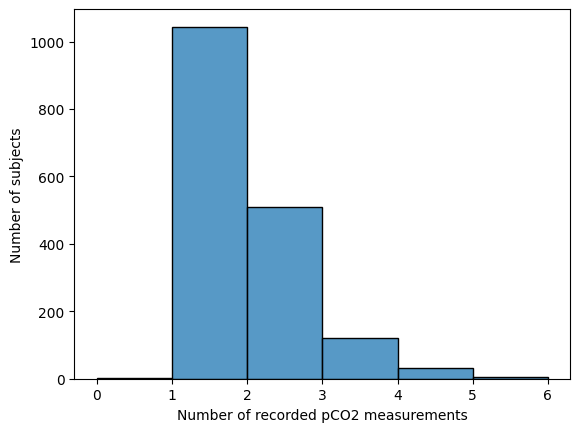

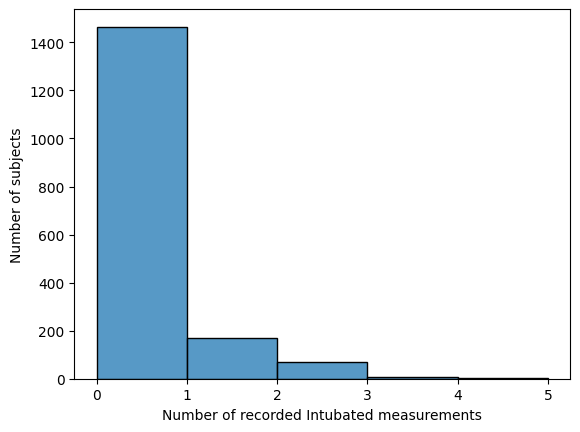

label,subject_id,Base Excess_count,Intubated_count,pCO2_count,pH_count,pO2_count
0,10012663,2,0,2,2,2
1,10015055,1,0,1,1,1
2,10016195,2,0,2,2,2
3,10025785,1,1,1,1,1
4,10028314,1,0,1,1,1


In [64]:
final_lab_counts = (
    final_labs.groupby(['subject_id', 'label'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
for l in relevant_labs:
    sns.histplot(final_lab_counts[l], binwidth=1, edgecolor='black')
    plt.xlabel(f"Number of recorded {l} measurements")
    plt.ylabel("Number of subjects")
    plt.show()
final_lab_counts = final_lab_counts.rename(columns={col: f"{col}_count" for col in final_lab_counts.columns if col != 'subject_id'})
final_lab_counts.head()

In [65]:
final_labs = pd.concat([
    final_labs[final_labs['label'].isin(latest_measurement)]
        .sort_values(['subject_id', 'label', 'charttime'])
        .groupby(['subject_id', 'label'], as_index=False)
        .last(),
    final_labs[final_labs['label'].isin(lowest_measurement)]
        .sort_values(['subject_id', 'label', 'valuenum'])
        .groupby(['subject_id', 'label'], as_index=False)
        .first()
], ignore_index=True)
final_labs.head()

,subject_id,label,charttime,valuenum,flag
0,10012663,Base Excess,2171-05-18 13:14:00,-5.0,<NA>
1,10012663,pCO2,2171-05-18 13:14:00,41.0,<NA>
2,10012663,pO2,2171-05-18 13:14:00,52.0,abnormal
3,10015055,Base Excess,2133-08-30 12:55:00,2.0,<NA>
4,10015055,pCO2,2133-08-30 12:55:00,38.0,<NA>


In [66]:
final_labs_wide = final_labs.pivot_table(
    index=key,
    columns='label',
    values=lab_covariates,
    aggfunc='first'
)
final_labs_wide.columns = [f"{lbl}_{col}" for col, lbl in final_labs_wide.columns]
final_labs_wide = final_labs_wide.reset_index()
final_labs_wide = final_labs_wide.merge(final_lab_counts, on='subject_id')
final_labs_wide

,subject_id,Base Excess_charttime,Intubated_charttime,pCO2_charttime,pH_charttime,pO2_charttime,pCO2_flag,pH_flag,pO2_flag,Base Excess_valuenum,pCO2_valuenum,pH_valuenum,pO2_valuenum,Base Excess_count,Intubated_count,pCO2_count,pH_count,pO2_count
0,10012663,2171-05-18 13:14:00,NaT,2171-05-18 13:14:00,2171-05-18 11:26:00,2171-05-18 13:14:00,<NA>,abnormal,abnormal,-5.0,41.0,7.14,52.0,2,0,2,2,2
1,10015055,2133-08-30 12:55:00,NaT,2133-08-30 12:55:00,2133-08-30 12:55:00,2133-08-30 12:55:00,<NA>,abnormal,abnormal,2.0,38.0,7.46,48.0,1,0,1,1,1
2,10016195,2161-09-17 01:02:00,NaT,2161-09-17 01:02:00,2161-09-17 01:02:00,2161-09-17 01:02:00,abnormal,<NA>,abnormal,-3.0,35.0,7.38,35.0,2,0,2,2,2
3,10025785,2155-06-14 19:11:00,2155-06-14 19:11:00,2155-06-14 19:11:00,2155-06-14 19:11:00,2155-06-14 19:11:00,abnormal,abnormal,abnormal,-5.0,52.0,7.24,132.0,1,1,1,1,1
4,10028314,2116-06-15 21:28:00,NaT,2116-06-15 21:28:00,2116-06-15 21:28:00,2116-06-15 21:28:00,abnormal,<NA>,abnormal,1.0,48.0,7.37,54.0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1711,19968042,2185-04-29 08:07:00,NaT,2185-04-29 08:07:00,2185-04-29 08:07:00,2185-04-29 08:07:00,abnormal,abnormal,abnormal,0.0,57.0,7.32,42.0,1,0,1,1,1
1712,19980633,2138-06-09 23:02:00,NaT,2138-06-09 23:02:00,2138-06-09 18:54:00,2138-06-09 23:02:00,abnormal,abnormal,abnormal,0.0,62.0,7.25,58.0,2,0,2,2,2
1713,19981800,2146-07-21 02:24:00,NaT,2146-07-21 02:24:00,2146-07-21 02:24:00,2146-07-21 02:24:00,abnormal,abnormal,abnormal,0.0,59.0,7.32,25.0,1,0,1,1,1
1714,19993227,2116-09-09 16:16:00,NaT,2116-09-09 16:16:00,2116-09-09 16:16:00,2116-09-09 16:16:00,<NA>,abnormal,abnormal,-4.0,40.0,7.33,59.0,1,0,1,1,1


In [67]:
# Get rid of cohort who have none of the relevant labs recorded
final_final_cohort = final_cohort[key + [outcome] + patient_covariates].merge(final_labs_wide, on='subject_id', how='inner')
final_final_cohort.head()

,subject_id,hospital_expire_flag,gender,ga,bw,admittime,intime,dischtime,deathtime,anchor_year,...,pO2_flag,Base Excess_valuenum,pCO2_valuenum,pH_valuenum,pO2_valuenum,Base Excess_count,Intubated_count,pCO2_count,pH_count,pO2_count
0,10012663,0,F,27-28,750-999,2171-05-18 10:54:00,2171-05-18 11:05:04,2171-07-21 15:30:00,NaT,2171,...,abnormal,-5.0,41.0,7.14,52.0,2,0,2,2,2
1,10015055,0,F,33-34,1500-1749,2133-08-30 08:04:00,2133-08-30 08:09:56,2133-09-23 13:00:00,NaT,2133,...,abnormal,2.0,38.0,7.46,48.0,1,0,1,1,1
2,10016195,0,M,35-36,None,2161-09-16 21:23:00,2161-09-16 21:26:17,2161-09-22 14:08:00,NaT,2161,...,abnormal,-3.0,35.0,7.38,35.0,2,0,2,2,2
3,10025785,0,F,31-32,1500-1749,2155-06-14 18:37:00,2155-06-14 18:58:56,2155-07-09 14:10:00,NaT,2155,...,abnormal,-5.0,52.0,7.24,132.0,1,1,1,1,1
4,10028314,0,M,31-32,1750-1999,2116-06-15 16:45:00,2116-06-15 17:15:40,2116-07-20 12:40:00,NaT,2116,...,abnormal,1.0,48.0,7.37,54.0,1,0,1,1,1


In [68]:
final_final_cohort[outcome].value_counts(), final_final_cohort[outcome].value_counts() / len(final_final_cohort)

(hospital_expire_flag
 0    1642
 1      74
 Name: count, dtype: int64,
 hospital_expire_flag
 0    0.956876
 1    0.043124
 Name: count, dtype: float64)

In [69]:
[col for col in final_final_cohort.columns if any(lab in col for lab in ['Base Excess'])]

['Base Excess_charttime', 'Base Excess_valuenum', 'Base Excess_count']

In [70]:
final_final_cohort.head()

,subject_id,hospital_expire_flag,gender,ga,bw,admittime,intime,dischtime,deathtime,anchor_year,...,pO2_flag,Base Excess_valuenum,pCO2_valuenum,pH_valuenum,pO2_valuenum,Base Excess_count,Intubated_count,pCO2_count,pH_count,pO2_count
0,10012663,0,F,27-28,750-999,2171-05-18 10:54:00,2171-05-18 11:05:04,2171-07-21 15:30:00,NaT,2171,...,abnormal,-5.0,41.0,7.14,52.0,2,0,2,2,2
1,10015055,0,F,33-34,1500-1749,2133-08-30 08:04:00,2133-08-30 08:09:56,2133-09-23 13:00:00,NaT,2133,...,abnormal,2.0,38.0,7.46,48.0,1,0,1,1,1
2,10016195,0,M,35-36,None,2161-09-16 21:23:00,2161-09-16 21:26:17,2161-09-22 14:08:00,NaT,2161,...,abnormal,-3.0,35.0,7.38,35.0,2,0,2,2,2
3,10025785,0,F,31-32,1500-1749,2155-06-14 18:37:00,2155-06-14 18:58:56,2155-07-09 14:10:00,NaT,2155,...,abnormal,-5.0,52.0,7.24,132.0,1,1,1,1,1
4,10028314,0,M,31-32,1750-1999,2116-06-15 16:45:00,2116-06-15 17:15:40,2116-07-20 12:40:00,NaT,2116,...,abnormal,1.0,48.0,7.37,54.0,1,0,1,1,1


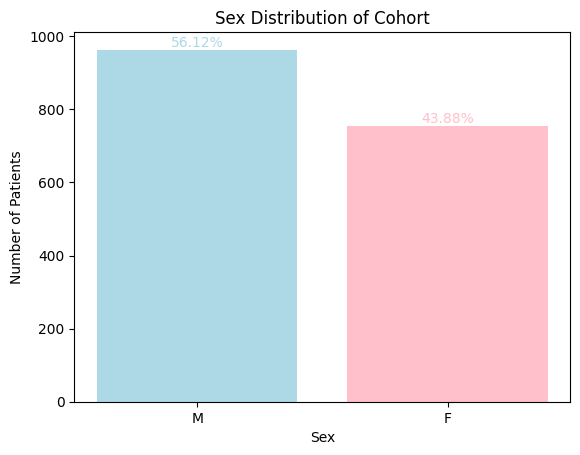

In [71]:
sex = final_final_cohort['gender'].value_counts(dropna=False)
sex_prop = [num/len(final_final_cohort)*100 for num in sex]
bars = plt.bar(sex.index, sex.values, color=['lightblue', 'pink'])
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, 
            f'{sex_prop[i]:.2f}%', ha='center', va='bottom', color=['lightblue', 'pink'][i])
plt.ylabel("Number of Patients")
plt.xlabel("Sex")
plt.title("Sex Distribution of Cohort")
plt.show()

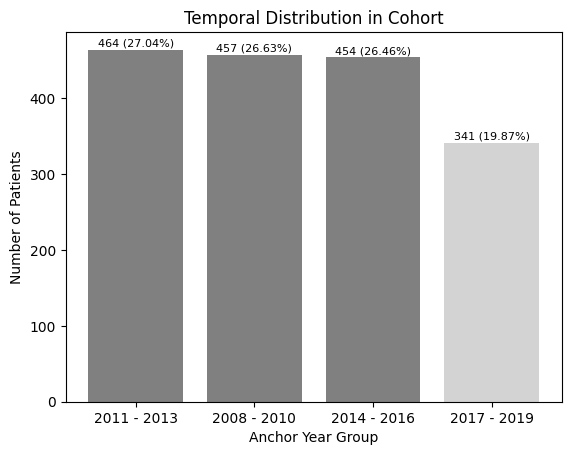

In [72]:
anchor_year_group = final_final_cohort['anchor_year_group'].value_counts()
bars = plt.bar(anchor_year_group.index, anchor_year_group.values, color=['gray','gray','gray','lightgray'])
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, 
            f'{anchor_year_group.values[i]} ({anchor_year_group.values[i]/len(final_final_cohort)*100:.2f}%)', ha='center', va='bottom', fontsize=8)
plt.xlabel("Anchor Year Group")
plt.ylabel("Number of Patients")
plt.title("Temporal Distribution in Cohort")
plt.show()

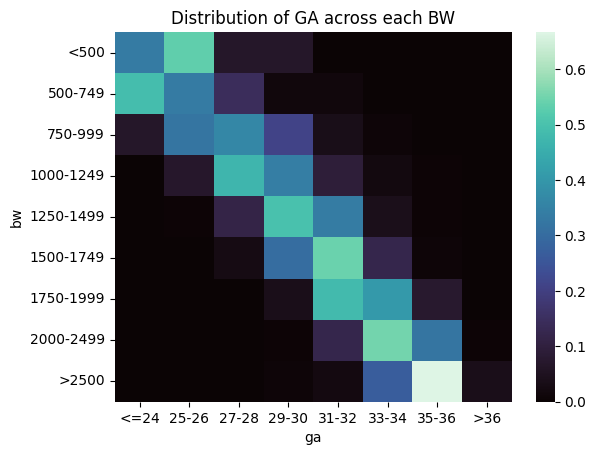

In [73]:
ga_by_bw = pd.crosstab(final_final_cohort['bw'], final_final_cohort['ga'], normalize='index').reindex(bw, columns=ga)
sns.heatmap(ga_by_bw.iloc[:-1,:-1], cmap='mako')
plt.title('Distribution of GA across each BW')
plt.show()

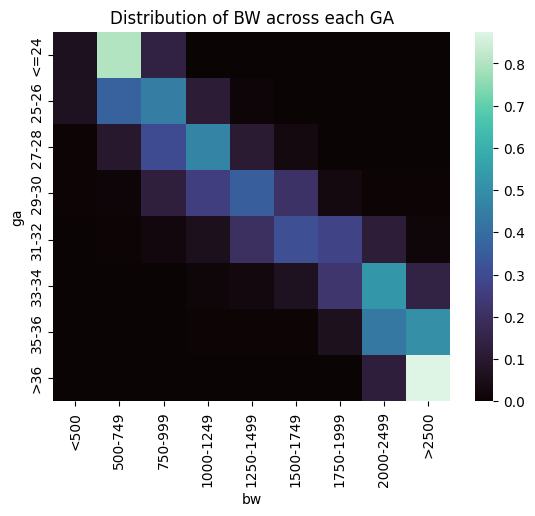

In [74]:
bw_by_ga = pd.crosstab(final_final_cohort['ga'], final_final_cohort['bw'], normalize='index').reindex(ga, columns=bw)
sns.heatmap(bw_by_ga.iloc[:-1,:-1], cmap='mako')
plt.title('Distribution of BW across each GA')
plt.show()

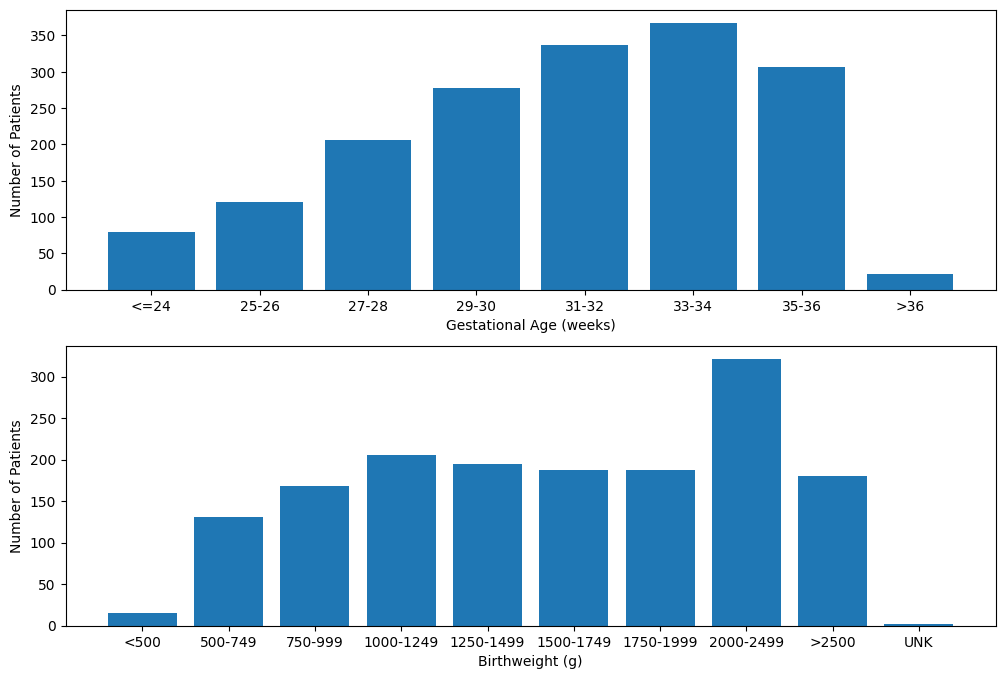

In [75]:
ga_counts = final_final_cohort['ga'].value_counts().reindex(ga)
bw_counts = final_final_cohort['bw'].value_counts().reindex(bw)
fig, ax = plt.subplots(2, figsize=(12,8))
ax[0].bar(ga_counts.index, ga_counts.values)
ax[0].set_xlabel('Gestational Age (weeks)')
ax[0].set_ylabel('Number of Patients')
ax[1].bar(bw_counts.index, bw_counts.values)
ax[1].set_xlabel('Birthweight (g)')
ax[1].set_ylabel('Number of Patients')
fig.show()

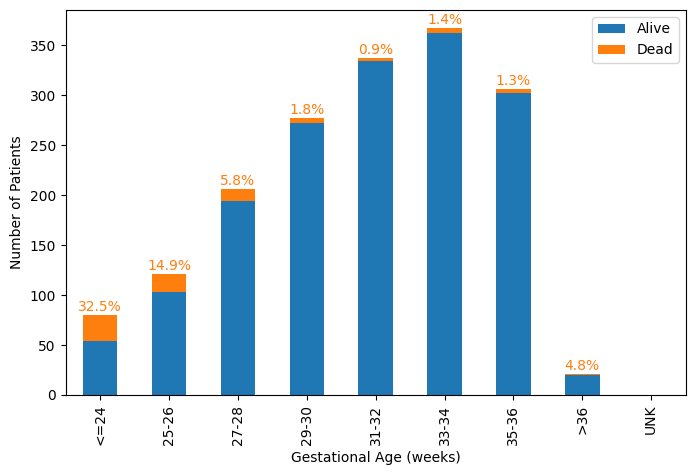

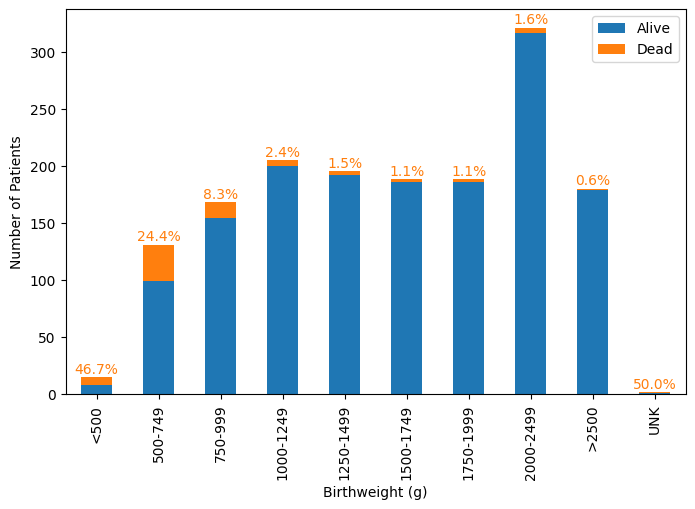

In [76]:
ga_outcome_counts = final_final_cohort.groupby(['ga', 'hospital_expire_flag']).size().reset_index(name='count')
ga_outcome_counts['ga'] = pd.Categorical(ga_outcome_counts['ga'], categories=ga, ordered=True)
ga_outcome_counts['hospital_expire_flag'] = pd.Categorical(ga_outcome_counts['hospital_expire_flag'], categories=[0,1], ordered=True)
ga_outcome_counts = ga_outcome_counts.sort_values(['ga','hospital_expire_flag'])
bw_outcome_counts = final_final_cohort.groupby(['bw', 'hospital_expire_flag']).size().reset_index(name='count')
bw_outcome_counts['bw'] = pd.Categorical(bw_outcome_counts['bw'], categories=bw, ordered=True)
bw_outcome_counts['hospital_expire_flag'] = pd.Categorical(bw_outcome_counts['hospital_expire_flag'], categories=[0,1], ordered=True)
bw_outcome_counts = bw_outcome_counts.sort_values(['bw','hospital_expire_flag'])
ga_outcome_counts = ga_outcome_counts.pivot(index='ga', columns='hospital_expire_flag', values='count').reindex(ga)
bw_outcome_counts = bw_outcome_counts.pivot(index='bw', columns='hospital_expire_flag', values='count').reindex(bw)
ax = ga_outcome_counts.plot(kind='bar', stacked=True, figsize=(8,5))
for i, x in enumerate(ga_outcome_counts.index):
    alive = ga_outcome_counts.loc[x, 0]
    dead = ga_outcome_counts.loc[x, 1]
    total = alive + dead
    if total > 0:
        pct_dead = 100 * dead / total
        ax.text(i, total + 1, f"{pct_dead:.1f}%", ha='center', va='bottom', fontsize=10, color='C1')
ax.set_xlabel('Gestational Age (weeks)')
ax.set_ylabel('Number of Patients')
ax.legend(labels=['Alive', 'Dead'])
ax = bw_outcome_counts.plot(kind='bar', stacked=True, figsize=(8,5))
for i, x in enumerate(bw_outcome_counts.index):
    alive = bw_outcome_counts.loc[x, 0]
    dead = bw_outcome_counts.loc[x, 1]
    total = alive + dead
    if total > 0:
        pct_dead = 100 * dead / total
        ax.text(i, total + 1, f"{pct_dead:.1f}%", ha='center', va='bottom', fontsize=10, color='C1')
ax.set_xlabel('Birthweight (g)')
ax.set_ylabel('Number of Patients')
ax.legend(labels=['Alive', 'Dead'])
plt.show()

In [77]:
final_final_cohort['ga'] = final_final_cohort['ga'].replace('UNK', np.nan)
final_final_cohort['bw'] = final_final_cohort['bw'].replace('UNK', np.nan)

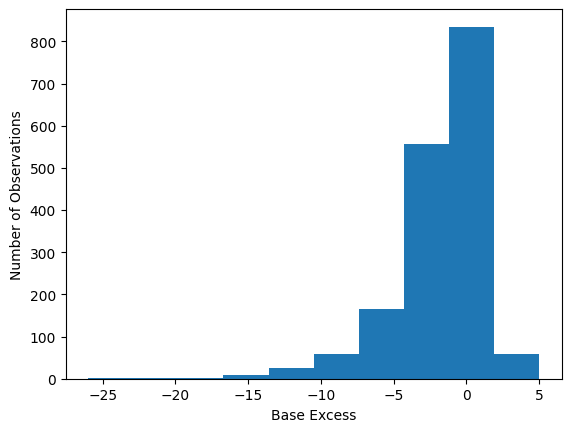

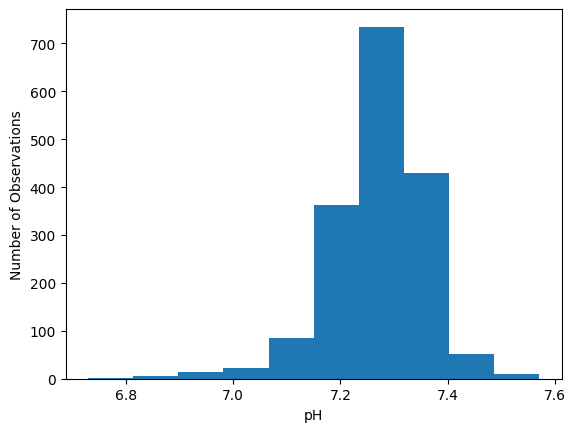

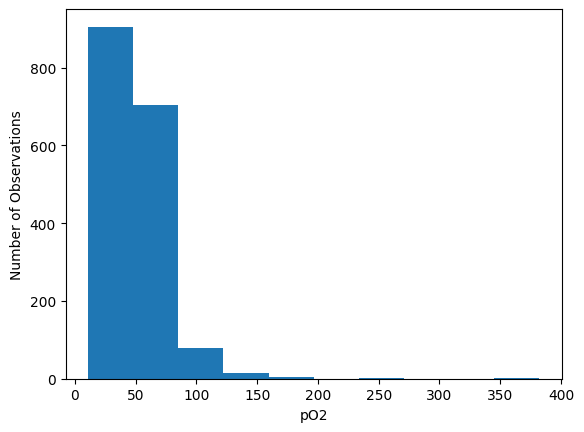

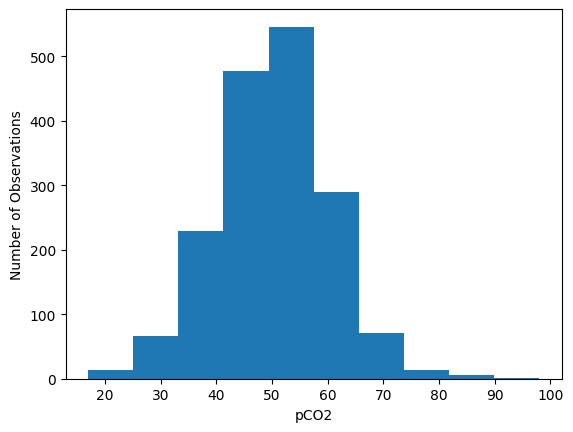

In [78]:
for lab in relevant_labs:
    lab_col = f'{lab}_valuenum'
    if lab_col in final_final_cohort:
        plt.hist(final_final_cohort[lab_col])
        plt.xlabel(lab)
        plt.ylabel('Number of Observations')
        plt.show()

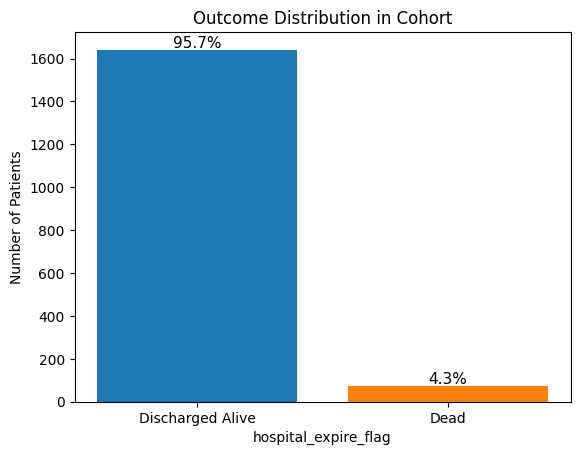

In [79]:
expiry = final_final_cohort['hospital_expire_flag'].value_counts()
bars = plt.bar(expiry.index, expiry.values, color=['C0', 'C1'])
percentages = [(val / sum(expiry.values)) * 100 for val in expiry.values]
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage_text = f'{percentages[i]:.1f}%' 
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height-4,                          
        percentage_text,
        ha='center',                       
        va='bottom',                       
        fontsize=11,
        color='black'
    )
plt.xticks([0,1], ['Discharged Alive','Dead'])
plt.xlabel("hospital_expire_flag")
plt.ylabel("Number of Patients")
plt.title("Outcome Distribution in Cohort")
plt.show()

In [80]:
final_final_cohort.to_csv('cohort.csv', index=False)

In [81]:
df = pd.read_csv('cohort.csv')

In [82]:
df['hospital_expire_flag'].value_counts() / len(df)

hospital_expire_flag
0    0.956876
1    0.043124
Name: count, dtype: float64

In [83]:
df['anchor_year_group'].value_counts() / len(df)

anchor_year_group
2011 - 2013    0.270396
2008 - 2010    0.266317
2014 - 2016    0.264569
2017 - 2019    0.198718
Name: count, dtype: float64

In [84]:
test_df = df[df['anchor_year_group'] == '2017 - 2019']
train_df = df[df['anchor_year_group'] != '2017 - 2019']
len(train_df), len(test_df)

(1375, 341)

In [85]:
train_df[outcome].value_counts() / len(train_df)

hospital_expire_flag
0    0.957818
1    0.042182
Name: count, dtype: float64

In [86]:
test_df[outcome].value_counts() / len(test_df)

hospital_expire_flag
0    0.953079
1    0.046921
Name: count, dtype: float64

In [87]:
X = train_df.drop(key+[outcome], axis=1)
y = train_df[outcome]
X_test = test_df.drop(key+[outcome], axis=1)
y_test = test_df[outcome]

In [88]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [89]:
len(X_train)/len(df), len(X_val)/len(df), len(X_test)/len(df)

(0.6410256410256411, 0.16025641025641027, 0.1987179487179487)

In [90]:
X_train['bw_imputed'] = X_train['bw'].fillna(X_train.groupby('ga')['bw'].transform(lambda x: x[x.notna()].mode().iloc[0]))
X_train['ga_imputed'] = X_train['ga'].fillna(X_train.groupby('bw')['ga'].transform(lambda x: x[x.notna()].mode().iloc[0]))

In [91]:
X_train.columns

Index(['gender', 'ga', 'bw', 'admittime', 'intime', 'dischtime', 'deathtime',
       'anchor_year', 'anchor_year_group', 'Base Excess_charttime',
       'Intubated_charttime', 'pCO2_charttime', 'pH_charttime',
       'pO2_charttime', 'pCO2_flag', 'pH_flag', 'pO2_flag',
       'Base Excess_valuenum', 'pCO2_valuenum', 'pH_valuenum', 'pO2_valuenum',
       'Base Excess_count', 'Intubated_count', 'pCO2_count', 'pH_count',
       'pO2_count', 'bw_imputed', 'ga_imputed'],
      dtype='object')

In [92]:
X_train_feat = X_train[['gender', 'ga_imputed', 'bw_imputed', 'Intubated_count', 'pCO2_flag', 'pH_flag', 'pO2_flag', 'Base Excess_valuenum', 'pCO2_valuenum', 'pH_valuenum', 'pO2_valuenum']].copy()

In [93]:
for lab in relevant_labs:
    lab_col = f'{lab}_valuenum'
    if lab_col in X_train_feat: X_train_feat[lab_col] = X_train_feat[lab_col].fillna(X_train_feat[lab_col].mean())

In [94]:
for lab in relevant_labs:
    lab_col = f'{lab}_flag'
    if lab_col in X_train_feat: X_train_feat[lab_col] = X_train_feat[lab_col].fillna('normal')

In [95]:
X_train_feat[X_train_feat.isnull().any(axis=1)]

,gender,ga_imputed,bw_imputed,Intubated_count,pCO2_flag,pH_flag,pO2_flag,Base Excess_valuenum,pCO2_valuenum,pH_valuenum,pO2_valuenum


In [96]:
X_train_feat_enc = X_train_feat[['gender', 'ga_imputed', 'bw_imputed', 'Base Excess_valuenum', 'pCO2_valuenum', 'pH_valuenum', 'pO2_valuenum', 'Intubated_count']].copy()

In [97]:
X_train_feat_enc = pd.get_dummies(X_train_feat_enc, columns=['gender'])

In [98]:
bw_encoding = {cat: idx for idx, cat in enumerate(bw)}
ga_encoding = {cat: idx for idx, cat in enumerate(ga)}

In [99]:
X_train_feat_enc['bw_encoded'] = X_train_feat_enc['bw_imputed'].map(bw_encoding)
X_train_feat_enc['ga_encoded'] = X_train_feat_enc['ga_imputed'].map(ga_encoding)
X_train_feat_enc = X_train_feat_enc.drop(['bw_imputed', 'ga_imputed'], axis=1)

In [100]:
scaler = StandardScaler()

In [101]:
X_train_feat_enc[['Base Excess_valuenum', 'pCO2_valuenum', 'pH_valuenum', 'pO2_valuenum', 'Intubated_count']] = scaler.fit_transform(X_train_feat_enc[['Base Excess_valuenum', 'pCO2_valuenum', 'pH_valuenum', 'pO2_valuenum', 'Intubated_count']])

In [102]:
X_train_feat_enc

,Base Excess_valuenum,pCO2_valuenum,pH_valuenum,pO2_valuenum,Intubated_count,gender_F,gender_M,bw_encoded,ga_encoded
762,0.727370,0.544013,0.587504,0.879594,-0.413874,False,True,3,2
1250,0.727370,0.956104,0.229798,0.061047,-0.413874,False,True,4,4
81,-0.260246,-0.589238,-1.320257,-0.484651,-0.413874,False,True,3,5
809,0.398165,0.337967,0.229798,-0.484651,-0.413874,True,False,4,4
941,0.068959,-0.383192,0.587504,-0.120852,-0.413874,True,False,7,6
...,...,...,...,...,...,...,...,...,...
632,0.727370,-0.177147,1.064444,0.015572,-0.413874,True,False,1,0
176,-0.260246,-1.413421,1.183679,1.607191,-0.413874,True,False,2,2
1082,-1.247863,2.192378,-1.320257,-0.575600,-0.413874,False,True,4,3
1679,-0.918657,-0.383192,-0.008672,-0.484651,-0.413874,False,True,8,5


In [103]:
y_train.value_counts()

hospital_expire_flag
0    1054
1      46
Name: count, dtype: int64

In [104]:
smote = SMOTE(sampling_strategy=0.3) 
X_train_up, y_train_up = smote.fit_resample(X_train_feat_enc, y_train)
y_train_up.value_counts()

hospital_expire_flag
0    1054
1     316
Name: count, dtype: int64

In [105]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_up, y_train_up)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [106]:
y_train_pred = model.predict(X_train_up)
y_train_prob = model.predict_proba(X_train_up)[:,1]
print("Accuracy:", accuracy_score(y_train_up, y_train_pred))
print("AUC:", roc_auc_score(y_train_up, y_train_prob))
print("\nClassification Report:\n", classification_report(y_train_up, y_train_pred))

Accuracy: 0.8905109489051095
AUC: 0.9532372156702615

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93      1054
           1       0.70      0.93      0.80       316

    accuracy                           0.89      1370
   macro avg       0.84      0.91      0.86      1370
weighted avg       0.91      0.89      0.90      1370



In [107]:
results_df = pd.DataFrame({'Actual': y_train_up, 'Predicted': y_train_pred})
results_df['Correct'] = (results_df['Actual'] == results_df['Predicted']).astype(int)
accuracy_per_class = results_df.groupby('Actual')['Correct'].mean()
print(accuracy_per_class)

Actual
0    0.877609
1    0.933544
Name: Correct, dtype: float64


In [108]:
X_test['bw_imputed'] = X_test['bw'].fillna(X_test.groupby('ga')['bw'].transform(lambda x: x[x.notna()].mode().iloc[0]))
X_test['ga_imputed'] = X_test['ga'].fillna(X_test.groupby('bw')['ga'].transform(lambda x: x[x.notna()].mode().iloc[0]))
X_test_feat = X_test[['gender', 'ga_imputed', 'bw_imputed', 'pCO2_flag', 'pH_flag', 'pO2_flag', 'Base Excess_valuenum', 'pCO2_valuenum', 'pH_valuenum', 'pO2_valuenum', 'Intubated_count']].copy()
for lab in relevant_labs:
    lab_col = f'{lab}_valuenum'
    if lab_col in X_test_feat: X_test_feat[lab_col] = X_test_feat[lab_col].fillna(X_test_feat[lab_col].mean())
for lab in relevant_labs:
    lab_col = f'{lab}_flag'
    if lab_col in X_test_feat: X_test_feat[lab_col] = X_test_feat[lab_col].fillna('normal')
X_test_feat_enc = X_test_feat[['gender', 'ga_imputed', 'bw_imputed', 'Base Excess_valuenum', 'pCO2_valuenum', 'pH_valuenum', 'pO2_valuenum', 'Intubated_count']].copy()
X_test_feat_enc = pd.get_dummies(X_test_feat_enc, columns=['gender'])
X_test_feat_enc['bw_encoded'] = X_test_feat_enc['bw_imputed'].map(bw_encoding)
X_test_feat_enc['ga_encoded'] = X_test_feat_enc['ga_imputed'].map(ga_encoding)
X_test_feat_enc = X_test_feat_enc.drop(['bw_imputed', 'ga_imputed'], axis=1)
X_test_feat_enc[['Base Excess_valuenum', 'pCO2_valuenum', 'pH_valuenum', 'pO2_valuenum', 'Intubated_count']] = scaler.transform(X_test_feat_enc[['Base Excess_valuenum', 'pCO2_valuenum', 'pH_valuenum', 'pO2_valuenum', 'Intubated_count']])

In [109]:
y_test_pred = model.predict(X_test_feat_enc)
y_test_prob = model.predict_proba(X_test_feat_enc)[:,1]
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("AUC:", roc_auc_score(y_test, y_test_prob))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

Accuracy: 0.8914956011730205
AUC: 0.938076923076923

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94       325
           1       0.28      0.81      0.41        16

    accuracy                           0.89       341
   macro avg       0.63      0.85      0.68       341
weighted avg       0.96      0.89      0.92       341



In [110]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
results_df['Correct'] = (results_df['Actual'] == results_df['Predicted']).astype(int)
accuracy_per_class = results_df.groupby('Actual')['Correct'].mean()
print(accuracy_per_class)

Actual
0    0.895385
1    0.812500
Name: Correct, dtype: float64


In [111]:
feature_names = X_train_up.columns
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance['Absolute_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)
print(feature_importance)

                Feature  Coefficient  Absolute_Coefficient
6              gender_M     3.177767              3.177767
5              gender_F     2.962591              2.962591
8            ga_encoded    -0.836739              0.836739
0  Base Excess_valuenum    -0.716222              0.716222
2           pH_valuenum    -0.715052              0.715052
1         pCO2_valuenum    -0.465259              0.465259
3          pO2_valuenum     0.260447              0.260447
7            bw_encoded    -0.223129              0.223129
4       Intubated_count     0.130146              0.130146


In [112]:
model = RandomForestClassifier(n_estimators=10, max_depth=5, class_weight='balanced_subsample')
model.fit(X_train_up, y_train_up)

,n_estimators,10
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [113]:
y_train_pred = model.predict(X_train_up)
y_train_prob = model.predict_proba(X_train_up)[:,1]
print("Accuracy:", accuracy_score(y_train_up, y_train_pred))
print("AUC:", roc_auc_score(y_train_up, y_train_prob))
print("\nClassification Report:\n", classification_report(y_train_up, y_train_pred))

Accuracy: 0.9503649635036496
AUC: 0.991138339778541

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      1054
           1       0.83      0.99      0.90       316

    accuracy                           0.95      1370
   macro avg       0.91      0.96      0.93      1370
weighted avg       0.96      0.95      0.95      1370



In [114]:
y_test_pred = model.predict(X_test_feat_enc)
y_test_prob = model.predict_proba(X_test_feat_enc)[:,1]
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("AUC:", roc_auc_score(y_test, y_test_prob))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

Accuracy: 0.906158357771261
AUC: 0.8571153846153846

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       325
           1       0.21      0.38      0.27        16

    accuracy                           0.91       341
   macro avg       0.59      0.65      0.61       341
weighted avg       0.93      0.91      0.92       341

